# Introduction
In this tutorial, we will use `torch.package` to export and import [a DCGAN model for generating 64x64 images of fashion models](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_dcgan/) hosted on Torch Hub. 

![DCGAN](https://pytorch.org/assets/images/dcgan_fashionGen.jpg)





# Install the correct version of PyTorch

Install the nightly build of PyTorch to get access to the latest features for `torch.package`.

# Get and run the model

First, get the model using the example code from the Torch Hub page for DCGAN.




In [1]:
import torch

use_gpu = True if torch.cuda.is_available() else False
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=use_gpu)

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/zipball/hub" to /root/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/DCGAN_fashionGen-1d67302.pth" to /root/.cache/torch/hub/checkpoints/DCGAN_fashionGen-1d67302.pth
100%|██████████| 39.7M/39.7M [00:01<00:00, 27.8MB/s]


Average network found !


Now, modify the example code slightly to create a helper function that runs a given model and shows the generated output. This function will be useful later on to test that the imported version of the model generates images similar to the one that was exported.

In [2]:
def run_model(model):
  num_images = 64
  noise, _ = model.buildNoiseData(num_images)
  with torch.no_grad():
    generated_images = model.test(noise)

  # let's plot these images using torchvision and matplotlib
  import matplotlib.pyplot as plt
  import torchvision
  plt.imshow(torchvision.utils.make_grid(generated_images).permute(1, 2, 0).cpu().numpy())

Finally, pass the model to this `run_model` function to make sure it works.

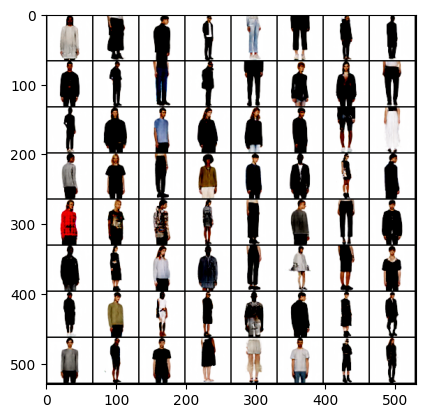

In [3]:
run_model(model)

Having confirmed that the model works and produces sensible output, let's see how it can be exported using `torch.package`.

# Export the model
To export the model, use `torch.package.PackageExporter` to specify where the package should be created and everything that should be stored in it.

In [4]:
from torch import package

path = "/tmp/dcgan.pt"
package_name = "dcgan"
resource_name = "model.pkl"

with package.PackageExporter(path) as exp:
    exp.save_pickle(package_name, resource_name, model)

/usr/local/lib/python3.9/dist-packages/torch/package/package_exporter.py:925: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_type_str = obj.pickle_storage_type()
/usr/local/lib/python3.9/dist-packages/torch/package/package_exporter.py:928: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_numel = obj.size()


PackagingError: ignored

Oh no!

In order to create a hermetic package, `PackageExporter` tries to access the source code of all dependencies needed by the modules and objects that will be saved. It skips any dependencies marked as `extern`, `mock`, and not marked as `intern`. Interns, externs, and mocks can be specified by name or by glob. Based on the error message above, `models.**` needs to be interned so that all the listed modules, which are part of the model of interest, are packaged.

In [5]:
with package.PackageExporter(path) as exp:
    exp.intern("models.**")
    exp.save_pickle(package_name, resource_name, model)

PackagingError: ignored

The `numpy` module is not a core part of the model being packaged, and can be marked as `extern`:

In [6]:
with package.PackageExporter(path) as exp:
    exp.extern("numpy.**")
    exp.intern("models.**")
    exp.save_pickle(package_name, resource_name, model)

# Importing the model

To import the model, use `torch.package.PackageImporter` to specify the path of the package and which resources should be loaded.

In [7]:
imp = package.PackageImporter(path)
loaded_model = imp.load_pickle(package_name, resource_name)

/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Then, call the previously defined `run_model` function to make sure the output matches.

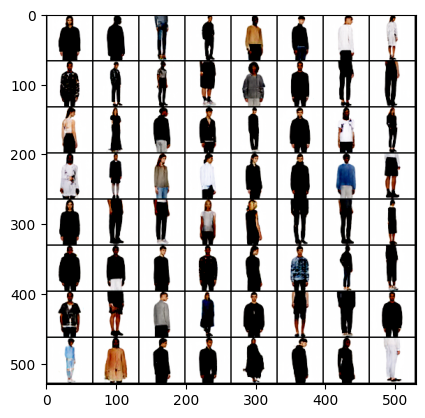

In [8]:
run_model(loaded_model)

And that's it! You have successfully packaged and imported your first model!